# Learn To Synchronize Videos

## Model declaration

In [1]:
from importlib import reload
import torch
import torch.nn as nn
import torchvision.models as models
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader
import numpy as np
import os
from matplotlib import pyplot as plt
import sync_net
import trainer
import metrics
reload(sync_net)
reload(trainer)
reload(metrics)
from sync_net import reset_first_layer, replace_last_layer, add_sigmoid_activation, TripletNet, TripletLoss, CosineSimilarityTripletLoss, LosslessTripletLoss
from data_loader import get_datasets, get_test_set
from trainer import fit
from metrics import EmbeddingL2DistanceMetric, EmbeddingCosineSimilarityMetric
import wandb
wandb.init(project="learn-to-synchronize-videos")
cuda = torch.cuda.is_available()

torch.cuda.set_device(0)
embedding_net = models.resnet50(pretrained=True)
reset_first_layer(embedding_net)
replace_last_layer(embedding_net, 16)
# embedding_net = add_sigmoid_activation(embedding_net)  # Use only with LosslessTripletLoss
model = TripletNet(embedding_net)
model.cuda(0)
model = nn.DataParallel(model).cuda()
lr = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
loss_fn = TripletLoss(margin=0.5)
# loss_fn = CosineSimilarityTripletLoss(margin=0.5)
# loss_fn = LosslessTripletLoss()
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 20
log_interval = 100
start_epoch = 0
save_path = r"C:\Users\root\Projects\VideoSynchronizationWithPytorch\trainings\mnist_dist_loss"
if not os.path.isdir(save_path):
    os.makedirs(save_path)
wandb.config.lr = lr
wandb.config.optimizer = type(optimizer)
wandb.config.loss_fn = type(loss_fn)

wandb: ERROR To use wandb on Windows, you need to run the command "wandb run python <your_train_script>.py"


## Load dataset

In [2]:
training_path = r'C:\Users\root\Data\Angiographie'
validation_path = r'C:\Users\root\Data\Angiographie\KR-11'
training_set, validation_set = get_datasets(training_path, validation_path)

105 valid frames in C:\Users\root\Data\Angiographie\AA-4\export\LCA_30LAO25CAU
110 valid frames in C:\Users\root\Data\Angiographie\AA-4\export\LCA_30RAO
104 valid frames in C:\Users\root\Data\Angiographie\AA-4\export\LCA_30RAO25CAU
78 valid frames in C:\Users\root\Data\Angiographie\AA-4\export\LCA_AP
79 valid frames in C:\Users\root\Data\Angiographie\AA-4\export\LCA_LAT
121 valid frames in C:\Users\root\Data\Angiographie\AA-4\export\RCA_AP
113 valid frames in C:\Users\root\Data\Angiographie\AA-4\export\RCA_LAT
75 valid frames in C:\Users\root\Data\Angiographie\ABL-5\export\LCA_30LAO25CRA
78 valid frames in C:\Users\root\Data\Angiographie\ABL-5\export\LCA_30RAO
85 valid frames in C:\Users\root\Data\Angiographie\ABL-5\export\LCA_AP
85 valid frames in C:\Users\root\Data\Angiographie\ABL-5\export\LCA_LAT
39 valid frames in C:\Users\root\Data\Angiographie\ABL-5\export\RCA_AP
39 valid frames in C:\Users\root\Data\Angiographie\ABL-5\export\RCA_LAT
48 valid frames in C:\Users\root\Data\Angiogr

### Load MNIST dataset instead

In [2]:
import torchvision.datasets as datasets
import torchvision.transforms as transforms

transformations = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor()
])
mnist_trainset = datasets.MNIST(r"C:\Users\root\Data\MNIST", train=True, download=True, transform=transformations)

In [ ]:
from PIL import Image
from torch.utils.data import Dataset

class TripletMNIST(Dataset):
    """
    Train: For each sample (anchor) randomly chooses a positive and negative samples
    Test: Creates fixed triplets for testing
    """

    def __init__(self, mnist_dataset):
        self.mnist_dataset = mnist_dataset
        self.train = self.mnist_dataset.train
        self.transform = self.mnist_dataset.transform

        if self.train:
            self.train_labels = self.mnist_dataset.train_labels
            self.train_data = self.mnist_dataset.train_data
            self.labels_set = set(self.train_labels.numpy())
            self.label_to_indices = {label: np.where(self.train_labels.numpy() == label)[0]
                                     for label in self.labels_set}

        else:
            self.test_labels = self.mnist_dataset.test_labels
            self.test_data = self.mnist_dataset.test_data
            # generate fixed triplets for testing
            self.labels_set = set(self.test_labels.numpy())
            self.label_to_indices = {label: np.where(self.test_labels.numpy() == label)[0]
                                     for label in self.labels_set}

            random_state = np.random.RandomState(29)

            triplets = [[i,
                         random_state.choice(self.label_to_indices[self.test_labels[i].item()]),
                         random_state.choice(self.label_to_indices[
                                                 np.random.choice(
                                                     list(self.labels_set - set([self.test_labels[i].item()]))
                                                 )
                                             ])
                         ]
                        for i in range(len(self.test_data))]
            self.test_triplets = triplets

    def __getitem__(self, index):
        if self.train:
            img1, label1 = self.train_data[index], self.train_labels[index].item()
            positive_index = index
            while positive_index == index:
                positive_index = np.random.choice(self.label_to_indices[label1])
            negative_label = np.random.choice(list(self.labels_set - set([label1])))
            negative_index = np.random.choice(self.label_to_indices[negative_label])
            img2 = self.train_data[positive_index]
            img3 = self.train_data[negative_index]
        else:
            img1 = self.test_data[self.test_triplets[index][0]]
            img2 = self.test_data[self.test_triplets[index][1]]
            img3 = self.test_data[self.test_triplets[index][2]]

        img1 = Image.fromarray(img1.numpy(), mode='L')
        img2 = Image.fromarray(img2.numpy(), mode='L')
        img3 = Image.fromarray(img3.numpy(), mode='L')
        if self.transform is not None:
            img1 = self.transform(img1)
            img2 = self.transform(img2)
            img3 = self.transform(img3)
        return (img1, img2, img3)

    def __len__(self):
        return len(self.mnist_dataset)
    
    
triplet_mnist = TripletMNIST(mnist_trainset)
train_loader = DataLoader(triplet_mnist, batch_size=20, shuffle=True, num_workers=0)
# for batch_index, triplet in enumerate(train_loader):
#     for i, image in enumerate(triplet):
#         print(f"batch {batch_index}, i {i}, triplet {image.numpy().shape}")
#         plt.subplot(1, 3, i+1)
#         plt.imshow(image.view(224, 224).numpy())
#         plt.title("Anchor" if i == 0 else "Positive" if i == 1 else "Negative")
#     plt.show()
metrics = [EmbeddingL2DistanceMetric(), EmbeddingCosineSimilarityMetric()]
fit(train_loader, None, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval, start_epoch=start_epoch, save_progress_path=save_path, metrics=metrics)

c:\logiciels\anaconda3\envs\torch\lib\site-packages\torchvision\datasets\mnist.py:43: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
c:\logiciels\anaconda3\envs\torch\lib\site-packages\torchvision\datasets\mnist.py:53: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


Starting Epoch 0
Will sample from train_loader
Train: [0/60000 (0%)]	Loss: 1.349203	Elapsed time: 0:00:02.587560	EmbeddingL2DistanceMetric (pos-, neg+, diff+): (4.05, 3.87, -0.18)	EmbeddingCosineSimilarityMetric (pos+, neg-): (0.775, 0.775)
Train: [2000/60000 (3%)]	Loss: 0.562737	Elapsed time: 0:00:57.978190	EmbeddingL2DistanceMetric (pos-, neg+, diff+): (2.2, 4.93, 2.72)	EmbeddingCosineSimilarityMetric (pos+, neg-): (0.932, 0.846)
Train: [4000/60000 (7%)]	Loss: 0.076338	Elapsed time: 0:01:55.141402	EmbeddingL2DistanceMetric (pos-, neg+, diff+): (1.38, 3.88, 2.49)	EmbeddingCosineSimilarityMetric (pos+, neg-): (0.954, 0.864)
Train: [6000/60000 (10%)]	Loss: 0.062251	Elapsed time: 0:02:54.490556	EmbeddingL2DistanceMetric (pos-, neg+, diff+): (1.12, 3.68, 2.56)	EmbeddingCosineSimilarityMetric (pos+, neg-): (0.961, 0.869)
Train: [8000/60000 (13%)]	Loss: 0.059723	Elapsed time: 0:03:56.039547	EmbeddingL2DistanceMetric (pos-, neg+, diff+): (1.0, 3.65, 2.65)	EmbeddingCosineSimilarityMetric (pos

Train: [20000/60000 (33%)]	Loss: 0.028368	Elapsed time: 0:10:42.407307	EmbeddingL2DistanceMetric (pos-, neg+, diff+): (0.56, 4.1, 3.53)	EmbeddingCosineSimilarityMetric (pos+, neg-): (0.985, 0.895)
Train: [22000/60000 (37%)]	Loss: 0.019891	Elapsed time: 0:11:56.793261	EmbeddingL2DistanceMetric (pos-, neg+, diff+): (0.56, 4.1, 3.54)	EmbeddingCosineSimilarityMetric (pos+, neg-): (0.985, 0.897)
Train: [24000/60000 (40%)]	Loss: 0.019245	Elapsed time: 0:13:13.573886	EmbeddingL2DistanceMetric (pos-, neg+, diff+): (0.56, 4.14, 3.58)	EmbeddingCosineSimilarityMetric (pos+, neg-): (0.986, 0.901)
Train: [26000/60000 (43%)]	Loss: 0.025052	Elapsed time: 0:14:31.722401	EmbeddingL2DistanceMetric (pos-, neg+, diff+): (0.56, 4.15, 3.58)	EmbeddingCosineSimilarityMetric (pos+, neg-): (0.986, 0.903)
Train: [28000/60000 (47%)]	Loss: 0.026052	Elapsed time: 0:15:52.333820	EmbeddingL2DistanceMetric (pos-, neg+, diff+): (0.56, 4.12, 3.56)	EmbeddingCosineSimilarityMetric (pos+, neg-): (0.985, 0.897)
Train: [3000

Train: [40000/60000 (67%)]	Loss: 0.013863	Elapsed time: 0:24:39.999343	EmbeddingL2DistanceMetric (pos-, neg+, diff+): (0.56, 4.42, 3.86)	EmbeddingCosineSimilarityMetric (pos+, neg-): (0.993, 0.951)
Train: [42000/60000 (70%)]	Loss: 0.014952	Elapsed time: 0:26:15.509907	EmbeddingL2DistanceMetric (pos-, neg+, diff+): (0.55, 4.4, 3.84)	EmbeddingCosineSimilarityMetric (pos+, neg-): (0.993, 0.951)
Train: [44000/60000 (73%)]	Loss: 0.016413	Elapsed time: 0:27:53.198566	EmbeddingL2DistanceMetric (pos-, neg+, diff+): (0.55, 4.41, 3.85)	EmbeddingCosineSimilarityMetric (pos+, neg-): (0.993, 0.949)
Train: [46000/60000 (77%)]	Loss: 0.021467	Elapsed time: 0:29:33.933855	EmbeddingL2DistanceMetric (pos-, neg+, diff+): (0.56, 4.42, 3.86)	EmbeddingCosineSimilarityMetric (pos+, neg-): (0.993, 0.95)
Train: [48000/60000 (80%)]	Loss: 0.036190	Elapsed time: 0:31:16.156508	EmbeddingL2DistanceMetric (pos-, neg+, diff+): (0.56, 4.42, 3.85)	EmbeddingCosineSimilarityMetric (pos+, neg-): (0.993, 0.949)
Train: [5000

## Load training state

In [ ]:
load_state_path = save_path + r"\training_state_0.pth"
print(load_state_path)
state = torch.load(load_state_path)

start_epoch = int(state['epoch']) + 1
model.load_state_dict(state['model'])
optimizer.load_state_dict(state['optimizer'])
scheduler.load_state_dict(state['scheduler'])

## Train

In [6]:
torch.cuda.empty_cache()  # Doesn't always work to free the GPU memory

In [3]:
train_loader = DataLoader(training_set, batch_size=20, shuffle=True, num_workers=4)
val_loader = DataLoader(validation_set, batch_size=20, shuffle=True, num_workers=4)
metrics = [EmbeddingL2DistanceMetric(), EmbeddingCosineSimilarityMetric()]
fit(train_loader, val_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval, start_epoch=start_epoch, save_progress_path=save_path, metrics=metrics)

Starting Epoch 0
Will sample from train_loader
embeddings [(tensor([[0.4588, 0.8449, 0.3442, 0.4459, 0.7223, 0.6746, 0.7164, 0.4689, 0.3136,
         0.4157, 0.6448, 0.6549, 0.3217, 0.5121, 0.3905, 0.2472],
        [0.5293, 0.7688, 0.5042, 0.5777, 0.7767, 0.7826, 0.5173, 0.2656, 0.4384,
         0.3336, 0.8237, 0.5926, 0.2500, 0.5965, 0.6267, 0.5117]],
       device='cuda:0', grad_fn=<SigmoidBackward>), tensor([[0.5168, 0.8030, 0.5068, 0.4936, 0.7305, 0.6742, 0.6597, 0.4908, 0.3330,
         0.3478, 0.6778, 0.5961, 0.3523, 0.5446, 0.4276, 0.3794],
        [0.4609, 0.8200, 0.3485, 0.5560, 0.7782, 0.7870, 0.5825, 0.2660, 0.4304,
         0.3666, 0.8018, 0.6055, 0.2422, 0.5649, 0.5976, 0.3724]],
       device='cuda:0', grad_fn=<SigmoidBackward>), tensor([[0.4527, 0.8647, 0.3433, 0.4903, 0.7415, 0.6884, 0.6490, 0.5094, 0.3981,
         0.4280, 0.6643, 0.6271, 0.2561, 0.4475, 0.4047, 0.3097],
        [0.5374, 0.7549, 0.5223, 0.5896, 0.7560, 0.7996, 0.6188, 0.2579, 0.3702,
         0.3155, 0

IndexError: index 2 is out of bounds for dimension 0 with size 2

## Test trained model

In [8]:
load_state_path = save_path + r"\training_state_1.pth"
print(load_state_path)
state = torch.load(load_state_path)
model.load_state_dict(state['model'])
model.eval()   

C:\Users\root\Projects\VideoSynchronizationWithPytorch\trainings\fc_16_metrics\training_state_1.pth


DataParallel(
  (module): TripletNet(
    (embedding_net): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(

In [6]:
test_path = r'C:\Users\root\Data\Angiographie'
test_set = get_test_set(test_path)

105 valid frames in C:\Users\root\Data\Angiographie\AA-4\export\LCA_30LAO25CAU
110 valid frames in C:\Users\root\Data\Angiographie\AA-4\export\LCA_30RAO
104 valid frames in C:\Users\root\Data\Angiographie\AA-4\export\LCA_30RAO25CAU
78 valid frames in C:\Users\root\Data\Angiographie\AA-4\export\LCA_AP
79 valid frames in C:\Users\root\Data\Angiographie\AA-4\export\LCA_LAT
121 valid frames in C:\Users\root\Data\Angiographie\AA-4\export\RCA_AP
113 valid frames in C:\Users\root\Data\Angiographie\AA-4\export\RCA_LAT
75 valid frames in C:\Users\root\Data\Angiographie\ABL-5\export\LCA_30LAO25CRA
78 valid frames in C:\Users\root\Data\Angiographie\ABL-5\export\LCA_30RAO
85 valid frames in C:\Users\root\Data\Angiographie\ABL-5\export\LCA_AP
85 valid frames in C:\Users\root\Data\Angiographie\ABL-5\export\LCA_LAT
39 valid frames in C:\Users\root\Data\Angiographie\ABL-5\export\RCA_AP
39 valid frames in C:\Users\root\Data\Angiographie\ABL-5\export\RCA_LAT
48 valid frames in C:\Users\root\Data\Angiogr

Batch 1/56 with 103 sequences


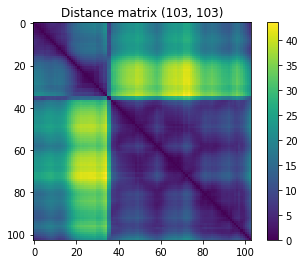

Batch 2/56 with 108 sequences


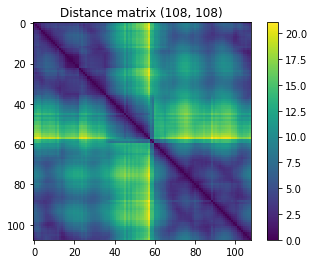

Batch 3/56 with 102 sequences


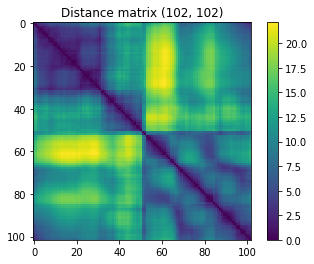

Batch 4/56 with 76 sequences


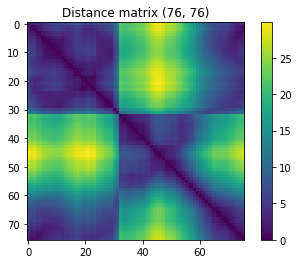

Batch 5/56 with 77 sequences


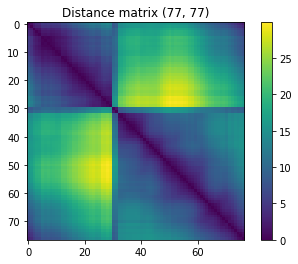

Batch 6/56 with 119 sequences


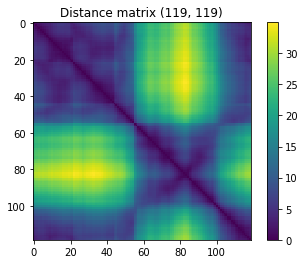

Batch 7/56 with 111 sequences


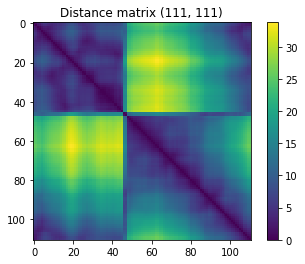

Batch 8/56 with 73 sequences


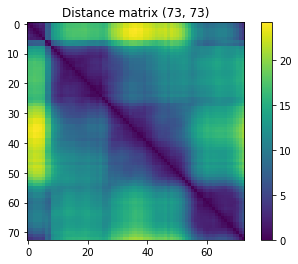

Batch 9/56 with 76 sequences


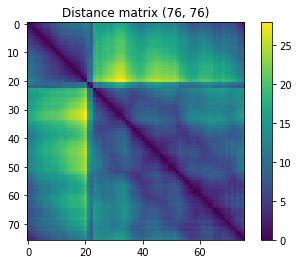

Batch 10/56 with 83 sequences


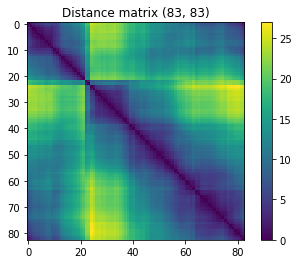

Batch 11/56 with 83 sequences


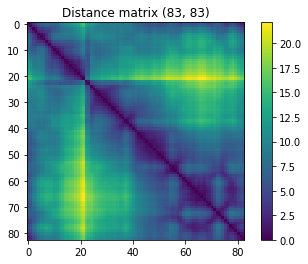

Batch 12/56 with 37 sequences


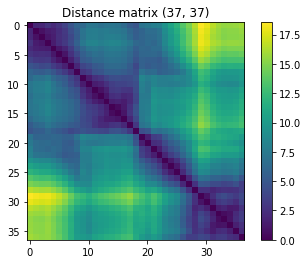

Batch 13/56 with 37 sequences


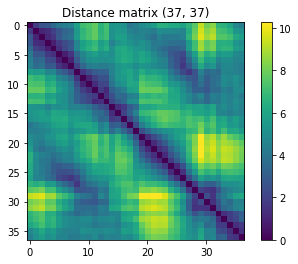

Batch 14/56 with 46 sequences


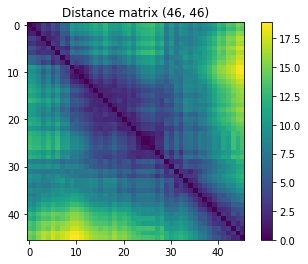

Batch 15/56 with 42 sequences


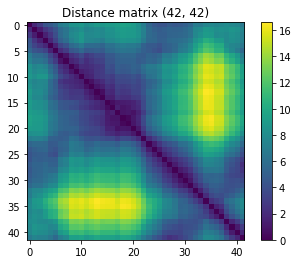

Batch 16/56 with 47 sequences


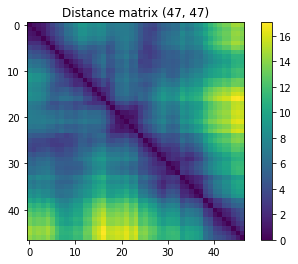

Batch 17/56 with 49 sequences


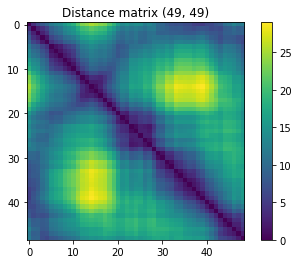

Batch 18/56 with 52 sequences


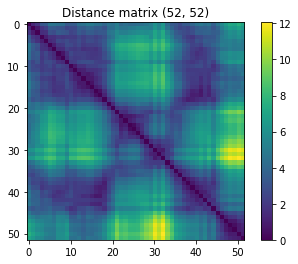

Batch 19/56 with 58 sequences


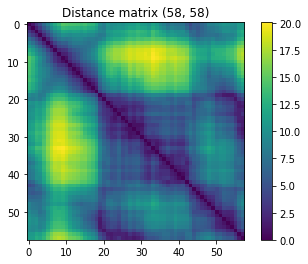

Batch 20/56 with 49 sequences


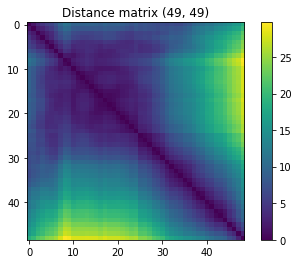

Batch 21/56 with 44 sequences


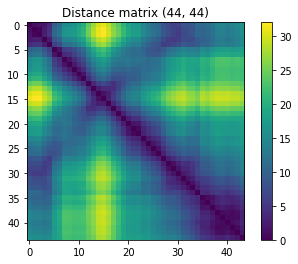

Batch 22/56 with 46 sequences


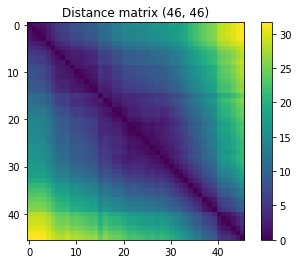

Batch 23/56 with 47 sequences


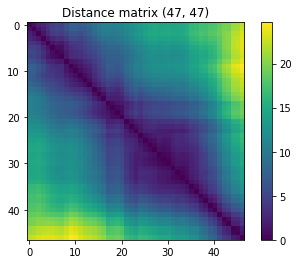

Batch 24/56 with 60 sequences


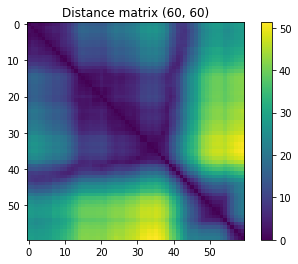

Batch 25/56 with 51 sequences


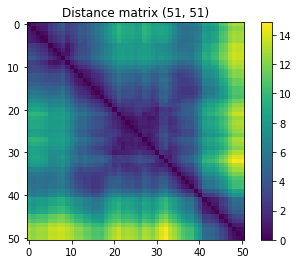

Batch 26/56 with 43 sequences


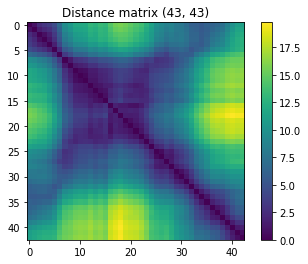

Batch 27/56 with 29 sequences


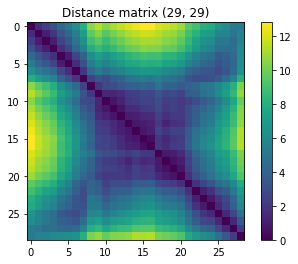

Batch 28/56 with 68 sequences


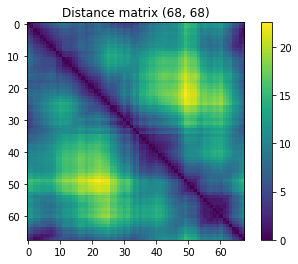

Batch 29/56 with 63 sequences


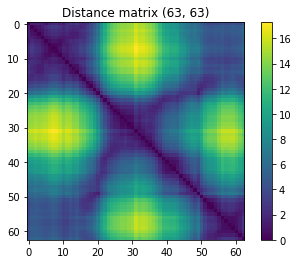

Batch 30/56 with 42 sequences


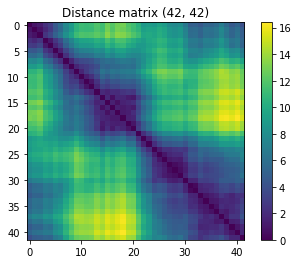

Batch 31/56 with 82 sequences


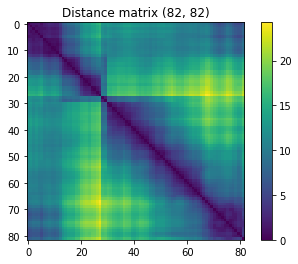

Batch 32/56 with 97 sequences


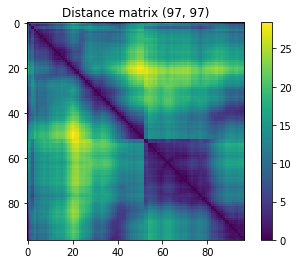

Batch 33/56 with 80 sequences


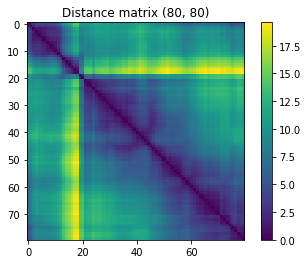

Batch 34/56 with 73 sequences


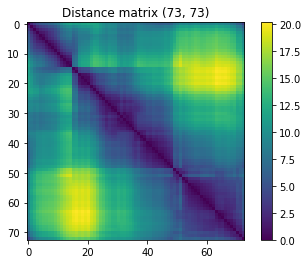

Batch 35/56 with 92 sequences


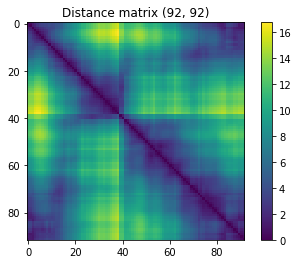

Batch 36/56 with 105 sequences


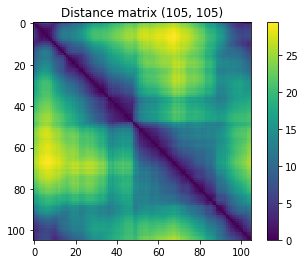

Batch 37/56 with 37 sequences


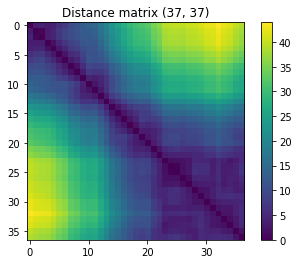

Batch 38/56 with 40 sequences


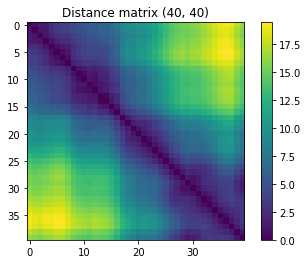

Batch 39/56 with 39 sequences


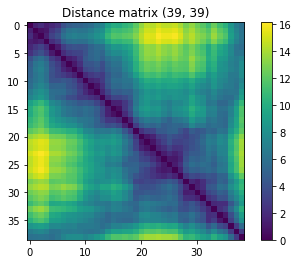

Batch 40/56 with 48 sequences


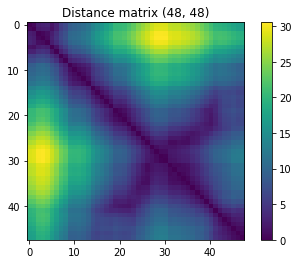

Batch 41/56 with 43 sequences


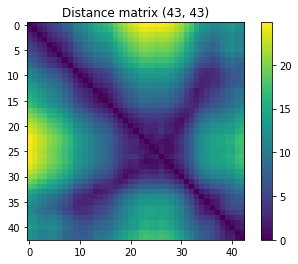

Batch 42/56 with 61 sequences


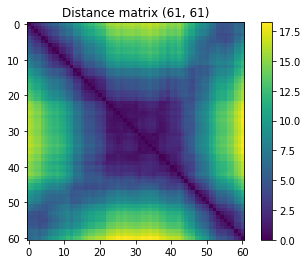

Batch 43/56 with 74 sequences


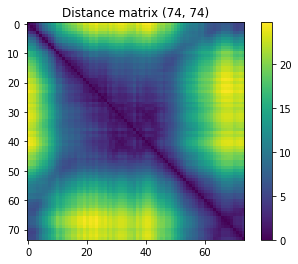

Batch 44/56 with 48 sequences


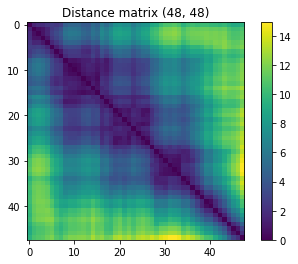

Batch 45/56 with 45 sequences


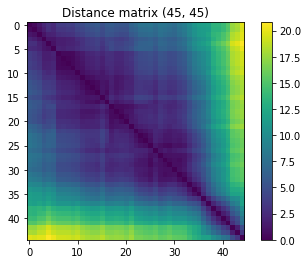

Batch 46/56 with 39 sequences


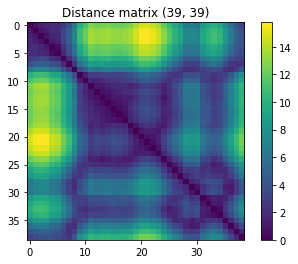

Batch 47/56 with 39 sequences


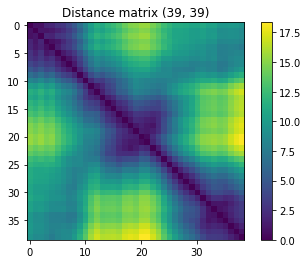

Batch 48/56 with 50 sequences


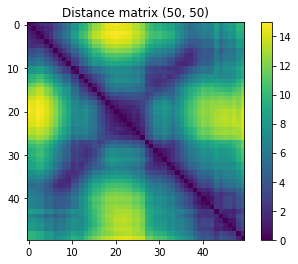

Batch 49/56 with 53 sequences


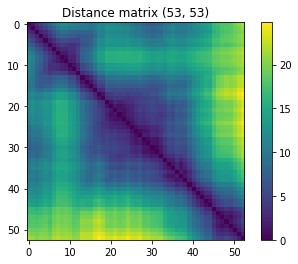

Batch 50/56 with 49 sequences


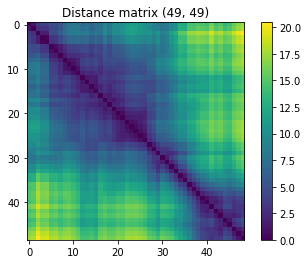

Batch 51/56 with 49 sequences


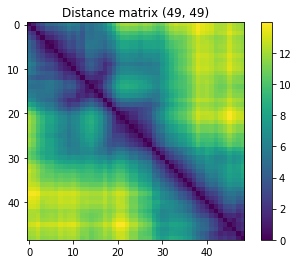

Batch 52/56 with 50 sequences


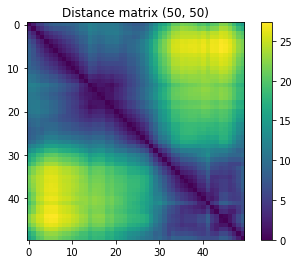

Batch 53/56 with 44 sequences


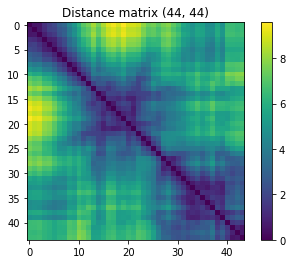

Batch 54/56 with 50 sequences


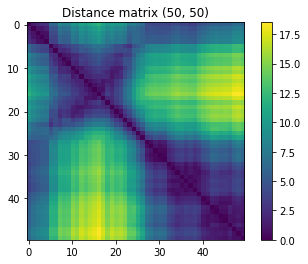

Batch 55/56 with 41 sequences


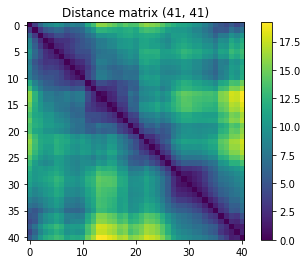

Batch 56/56 with 39 sequences


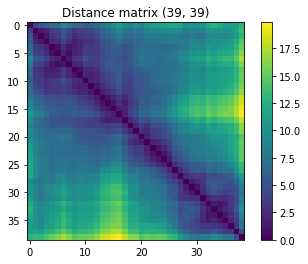

In [9]:
def calc_distance_matrix(embeddings):
    distances = []
    for i in range(len(embeddings)):
        distances_i = []
        for j in range(len(embeddings)):
            if j < i:
                distances_i.append(distances[j][i])
            elif j == i:
                distances_i.append(0)
            else:
                val = torch.sum(torch.abs(embeddings[i] - embeddings[j]))
                distances_i.append(val.cpu().numpy())
        distances.append(distances_i)
    distances = np.array(distances)
    return distances

with torch.no_grad():
    test_loader = DataLoader(test_set, batch_size=1, shuffle=False, num_workers=1)
    for batch_index, sequences in enumerate(test_loader):
        # sequences: (batch, video_frame, channel, width, height)
        embeddings = []
        print (f"Batch {batch_index + 1}/{len(test_loader)} with {len(sequences[0])} sequences")
        for i in range(len(sequences[0])):
            sequence = sequences[:, i]
            embedding = model(sequence) # (1, 1000)
            embeddings.append(embedding)
        distance_matrix = calc_distance_matrix(embeddings)
        plt.imshow(distance_matrix)
        plt.colorbar()
        plt.title(f"Distance matrix {distance_matrix.shape}")
        plt.show()